 # IDS_training_and_preprocessing

### Installation of Required Tools

Project Overview
The project aims to create an Intrusion Detection System (IDS) using machine learning to analyze and classify network traffic based on the Modbus protocol, a common protocol used in industrial systems.

Specifically, you want the IDS to:

Classify Modbus traffic as either safe or malicious.
Label specific types of attacks it detects.
Integrate with the xNIDS Explainer, which is a tool designed to explain why the IDS classified certain traffic as malicious, providing insights into the model's decisions.

In [12]:
# These commands ensure that TShark and PyShark are installed, allowing us to read and convert pcap data effectively.
!sudo apt-get install -y tshark
!pip install pyshark


^C
ERROR: Operation cancelled by user


In [1]:
# Data Conversion
!tshark -r CnC_uploading_exe_modbus_6RTU_with_operate.pcap

Running as user "root" and group "root". This could be dangerous.
    1   0.000000 192.168.1.100 → 192.168.1.101 TCP 62 1355 → 502 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    2   0.000218 192.168.1.101 → 192.168.1.100 TCP 62 502 → 1355 [SYN, ACK] Seq=0 Ack=1 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    3   0.000340 192.168.1.100 → 192.168.1.101 TCP 54 1355 → 502 [ACK] Seq=1 Ack=1 Win=64240 Len=0
    4   0.000898 192.168.1.100 → 192.168.1.101 Modbus/TCP 66    Query: Trans:  2260; Unit:   1, Func:   3: Read Holding Registers
    5   0.001468 192.168.1.100 → 192.168.1.106 TCP 62 1356 → 502 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    6   0.001639 192.168.1.106 → 192.168.1.100 TCP 62 502 → 1356 [SYN, ACK] Seq=0 Ack=1 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    7   0.001750 192.168.1.101 → 192.168.1.100 Modbus/TCP 71 Response: Trans:  2260; Unit:   1, Func:   3: Read Holding Registers
    8   0.001807 192.168.1.100 → 192.168.1.106 TCP 54 1356 → 502 [ACK] Seq=1 Ack=1 Win=64240 Len=

In [2]:
# # This command extracts the frame time, source IP, and destination IP fields and writes them to modbus_data.csv.
!tshark -r CnC_uploading_exe_modbus_6RTU_with_operate.pcap -T fields -e frame.time -e ip.hdr_len -e ip.ttl -e ip.proto -e ip.checksum -e ip.src -e ip.dst -e ip.len -e tcp.srcport -e tcp.dstport -e tcp.len -e tcp.hdr_len -e tcp.window_size -e tcp.checksum -e modbus.func_code -e modbus.byte_cnt -E header=y -E separator=, > modbus_data.csv
# Check if data was written to CSV
with open('modbus_data.csv', 'r') as file:
    print(file.read())

Running as user "root" and group "root". This could be dangerous.
frame.time,ip.hdr_len,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,tcp.srcport,tcp.dstport,tcp.len,tcp.hdr_len,tcp.window_size,tcp.checksum,modbus.func_code,modbus.byte_cnt
Feb 24, 2015 17:18:20.632394000 UTC,20,128,6,0xc2f1,192.168.1.100,192.168.1.101,48,1355,502,0,28,64240,0xdf25,,
Feb 24, 2015 17:18:20.632612000 UTC,20,128,6,0x1baf,192.168.1.101,192.168.1.100,48,502,1355,0,28,64240,0xc2b8,,
Feb 24, 2015 17:18:20.632734000 UTC,20,128,6,0xc2f8,192.168.1.100,192.168.1.101,40,1355,502,0,20,64240,0xef7c,,
Feb 24, 2015 17:18:20.633292000 UTC,20,128,6,0xc2eb,192.168.1.100,192.168.1.101,52,1355,502,12,20,64240,0xe57f,3,
Feb 24, 2015 17:18:20.633862000 UTC,20,128,6,0xc2e9,192.168.1.100,192.168.1.106,48,1356,502,0,28,64240,0x212e,,
Feb 24, 2015 17:18:20.634033000 UTC,20,128,6,0x6782,192.168.1.106,192.168.1.100,48,502,1356,0,28,64240,0x13cb,,
Feb 24, 2015 17:18:20.634144000 UTC,20,128,6,0x1ba5,192.168.1.101,192.168.1.100,57,

### Load the CSV into a DataFrame and covert data to numerical

In [3]:
import pandas as pd
# Loading the Data into Python
try:
    # Attempt to load data
    df = pd.read_csv('modbus_data.csv')
    print(df.head())
except pd.errors.EmptyDataError:
    print("No data found in the CSV. Verify that tshark extracted data correctly.")

# Convert the timestamp column to datetime format
df['frame.time'] = pd.to_numeric(pd.to_datetime(df['frame.time'], errors='coerce'))
df1 = pd.read_csv('/content/CnC_uploading_exe_modbus_6RTU_with_operate_labeled.csv',sep=';',index_col=0,header=None,names=['labels'])
df['label'] = df1['labels'].to_list()
print(df.columns)
df


                          frame.time  ip.hdr_len  ip.ttl  ip.proto  \
Feb 24   2015 17:18:20.632394000 UTC          20     128         6   
Feb 24   2015 17:18:20.632612000 UTC          20     128         6   
Feb 24   2015 17:18:20.632734000 UTC          20     128         6   
Feb 24   2015 17:18:20.633292000 UTC          20     128         6   
Feb 24   2015 17:18:20.633862000 UTC          20     128         6   

       ip.checksum         ip.src         ip.dst  ip.len  tcp.srcport  \
Feb 24      0xc2f1  192.168.1.100  192.168.1.101      48       1355.0   
Feb 24      0x1baf  192.168.1.101  192.168.1.100      48        502.0   
Feb 24      0xc2f8  192.168.1.100  192.168.1.101      40       1355.0   
Feb 24      0xc2eb  192.168.1.100  192.168.1.101      52       1355.0   
Feb 24      0xc2e9  192.168.1.100  192.168.1.106      48       1356.0   

        tcp.dstport  tcp.len  tcp.hdr_len  tcp.window_size tcp.checksum  \
Feb 24        502.0      0.0         28.0          64240.0       

<ipython-input-3-ae9b375e9a20>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['frame.time'] = pd.to_numeric(pd.to_datetime(df['frame.time'], errors='coerce'))


Index(['frame.time', 'ip.hdr_len', 'ip.ttl', 'ip.proto', 'ip.checksum',
       'ip.src', 'ip.dst', 'ip.len', 'tcp.srcport', 'tcp.dstport', 'tcp.len',
       'tcp.hdr_len', 'tcp.window_size', 'tcp.checksum', 'modbus.func_code',
       'modbus.byte_cnt', 'label'],
      dtype='object')


,frame.time,ip.hdr_len,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,tcp.srcport,tcp.dstport,tcp.len,tcp.hdr_len,tcp.window_size,tcp.checksum,modbus.func_code,modbus.byte_cnt,label
Feb 24,1420132700632394000,20,128,6,0xc2f1,192.168.1.100,192.168.1.101,48,1355.0,502.0,0.0,28.0,64240.0,0xdf25,NaN,NaN,0
Feb 24,1420132700632612000,20,128,6,0x1baf,192.168.1.101,192.168.1.100,48,502.0,1355.0,0.0,28.0,64240.0,0xc2b8,NaN,NaN,0
Feb 24,1420132700632734000,20,128,6,0xc2f8,192.168.1.100,192.168.1.101,40,1355.0,502.0,0.0,20.0,64240.0,0xef7c,NaN,NaN,0
Feb 24,1420132700633292000,20,128,6,0xc2eb,192.168.1.100,192.168.1.101,52,1355.0,502.0,12.0,20.0,64240.0,0xe57f,3.0,NaN,0
Feb 24,1420132700633862000,20,128,6,0xc2e9,192.168.1.100,192.168.1.106,48,1356.0,502.0,0.0,28.0,64240.0,0x212e,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Feb 24,1420132770668830000,20,128,6,0xbf5c,192.168.1.100,192.168.1.103,40,1499.0,502.0,0.0,20.0,64230.0,0x7dbe,NaN,NaN,0
Feb 24,1420132770669236000,20,128,6,0xbf5d,192.168.1.100,192.168.1.101,40,1500.0,502.0,0.0,20.0,64230.0,0xfba3,NaN,NaN,0
Feb 24,1420132770669351000,20,128,6,0x1ae1,192.168.1.101,192.168.1.100,40,502.0,1500.0,0.0,20.0,64228.0,0xfba5,NaN,NaN,0
Feb 24,1420132770669519000,20,128,6,0x1ae0,192.168.1.101,192.168.1.100,40,502.0,1500.0,0.0,20.0,64228.0,0xfba4,NaN,NaN,0


### Error Handling for Data and Model Loading

In [4]:
import joblib

# Load data with error handling
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        if data.empty:
            raise ValueError("Loaded file is empty. Please check the file content.")
        print("Data loaded successfully.")
        return data
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
    except pd.errors.EmptyDataError:
        print("Error: No data found in the file.")
    except Exception as e:
        print(f"Unexpected error occurred while loading data: {e}")
    return None

# Load model with error handling
def load_model(model_path):
    try:
        model = joblib.load(model_path)
        print("Model loaded successfully.")
        return model
    except FileNotFoundError:
        print(f"Error: Model file {model_path} not found.")
    except Exception as e:
        print(f"Unexpected error occurred while loading the model: {e}")
    return None


### Label Distribution

This is useful for understanding the balance between safe and malicious packets.

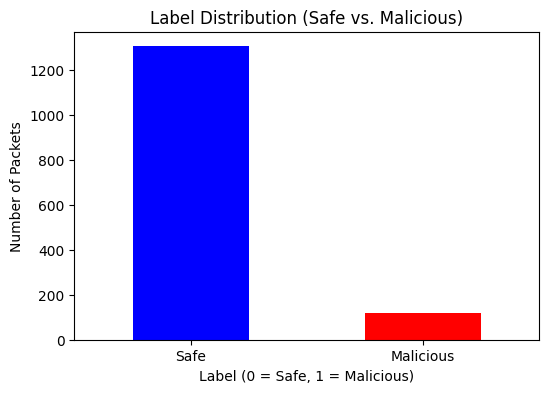

In [5]:
# Plot label distribution (safe vs. malicious)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title("Label Distribution (Safe vs. Malicious)")
plt.xlabel("Label (0 = Safe, 1 = Malicious)")
plt.ylabel("Number of Packets")
plt.xticks([0, 1], labels=["Safe", "Malicious"], rotation=0)
plt.show()

correlation matrix to check relationships.

## Data Preprocessing

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Example dataset
# df = pd.read_csv('your_file.csv')  # Replace with your actual data

# Binary Encoding Function
def ip_to_binary(ip):
    return ''.join([f'{int(octet):08b}' for octet in ip.split('.')])

# Apply binary encoding
df['ip.src'] = df['ip.src'].apply(ip_to_binary)
df['ip.dst'] = df['ip.dst'].apply(ip_to_binary)

# Split binary strings into columns
src_binary_columns = [f'ip.src_bit_{i}' for i in range(32)]
df[src_binary_columns] = df['ip.src'].apply(lambda x: pd.Series(list(x))).astype(int)

dst_binary_columns = [f'ip.dst_bit_{i}' for i in range(32)]
df[dst_binary_columns] = df['ip.dst'].apply(lambda x: pd.Series(list(x))).astype(int)

# Drop original IP columns
df.drop(columns=['ip.src', 'ip.dst'], inplace=True)

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Handle class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Ensure all features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill missing values if any
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Debug output
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Proceed to train the model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("Model training and prediction completed successfully.")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Training set size: (1827, 78)
Test set size: (783, 78)
Model training and prediction completed successfully.


In [6]:
X_train

,frame.time,ip.hdr_len,ip.ttl,ip.proto,ip.checksum,ip.len,tcp.srcport,tcp.dstport,tcp.len,tcp.hdr_len,...,ip.dst_bit_22,ip.dst_bit_23,ip.dst_bit_24,ip.dst_bit_25,ip.dst_bit_26,ip.dst_bit_27,ip.dst_bit_28,ip.dst_bit_29,ip.dst_bit_30,ip.dst_bit_31
949,1420132750663601000,20,128,6,0.0,50,502.0,1460.0,10.0,20.0,...,0,1,0,1,1,0,0,1,0,0
151,1420132700669863000,20,128,6,0.0,50,502.0,1372.0,10.0,20.0,...,0,1,0,1,1,0,0,1,0,0
1702,1420132744962138000,20,128,17,0.0,90,0.0,0.0,0.0,0.0,...,0,1,0,1,1,0,0,1,0,0
1056,1420132760650331000,20,128,6,0.0,48,1472.0,502.0,0.0,28.0,...,0,1,0,1,1,0,0,1,0,1
1210,1420132765648931000,20,128,6,0.0,688,1630.0,4444.0,648.0,20.0,...,0,1,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1420132765648547000,20,128,6,0.0,1500,1630.0,4444.0,1460.0,20.0,...,0,1,0,1,1,0,1,0,0,1
1095,1420132760661027000,20,128,6,0.0,40,502.0,1471.0,0.0,20.0,...,0,1,0,1,1,0,0,1,0,0
1130,1420132760666560000,20,128,6,0.0,50,502.0,1480.0,10.0,20.0,...,0,1,0,1,1,0,0,1,0,0
1294,1420132770641311000,20,128,6,0.0,40,502.0,1483.0,0.0,20.0,...,0,1,0,1,1,0,0,1,0,0


In [10]:
print("Resampled dataset size:", X_resampled.shape)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Resampled dataset size: (2610, 78)
Training set size: (1827, 78)
Test set size: (783, 78)


## Train a Machine Learning Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      1.00      1.00       392

    accuracy                           1.00       783
   macro avg       1.00      1.00      1.00       783
weighted avg       1.00      1.00      1.00       783



In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best parameters and model performance
print("Best Parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      1.00      1.00       392

    accuracy                           1.00       783
   macro avg       1.00      1.00      1.00       783
weighted avg       1.00      1.00      1.00       783



## Model Evaluation with Additional Metrics

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model with additional metrics
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=["Safe", "Malicious"]))

    # Display the ROC curve to visualize the model's performance in distinguishing between classes
    # ROC Curve and AUC Score
    if len(set(y_test)) == 2:  # Only applicable for binary classification
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC Curve and AUC not applicable for multi-class classification.")


Accuracy: 1.0


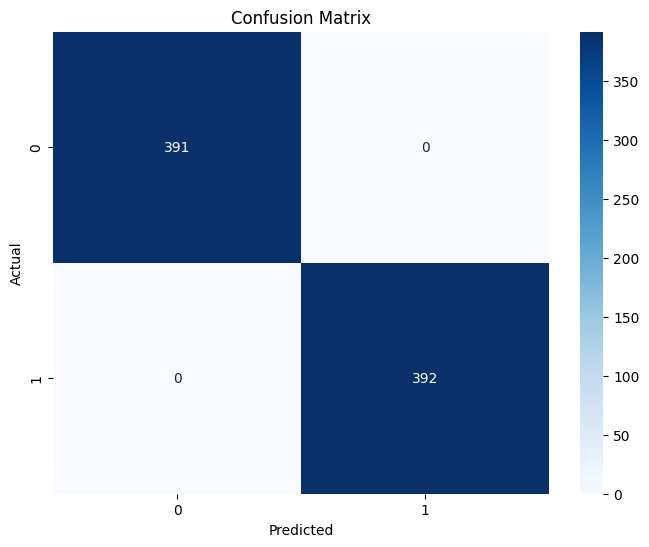

Classification Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       391
   Malicious       1.00      1.00      1.00       392

    accuracy                           1.00       783
   macro avg       1.00      1.00      1.00       783
weighted avg       1.00      1.00      1.00       783



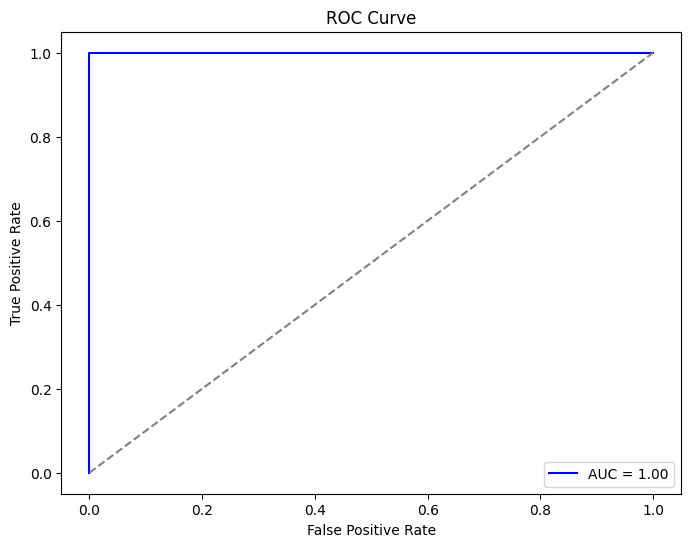

In [13]:
# Train the model
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Now evaluate the fitted model
evaluate_model(clf, X_test, y_test)


## Save the Model for Future Use

Saving the model enables you to load and use it later without retraining. This is particularly useful if you need to integrate it with other systems or explainable AI (e.g., xNIDS).

In [14]:
import joblib

# Save the trained model
joblib.dump(clf, 'modbus_ids_model.pkl')


['modbus_ids_model.pkl']

## Interpret the Model

To understand which features contribute most to the classification, you can check feature importances in the Random Forest model.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


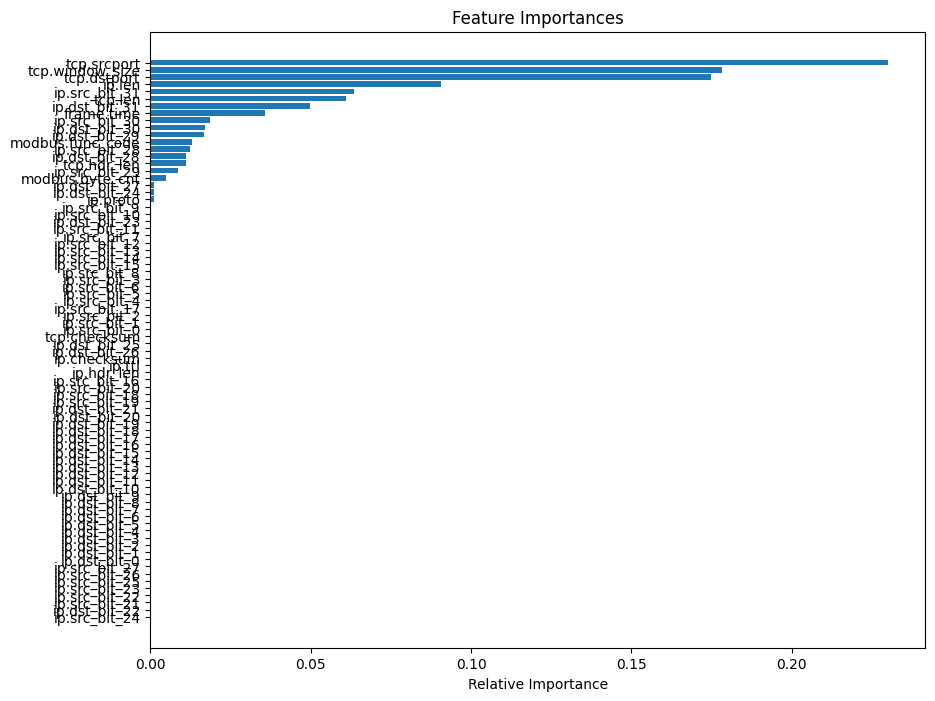

Model saved as modbus_ids_model.pkl in Google Drive.


In [16]:
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt

# Assuming X_train and y_train have been defined in your data preprocessing steps

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)  # Make sure to fit the model first

# Access feature importances after the model is fitted
importances = clf.feature_importances_
feature_names = X_train.columns
indices = importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# Optionally, save the fitted model for future use
#joblib.dump(clf, 'modbus_ids_model.pkl')
import joblib

# Save the trained model directly to Google Drive
joblib.dump(clf, '/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_ids_model.pkl')
print("Model saved as modbus_ids_model.pkl in Google Drive.")


In [ ]:
# import matplotlib.pyplot as plt

# # Plot feature importances
# importances = clf.feature_importances_
# feature_names = X.columns
# indices = importances.argsort()

# plt.figure(figsize=(10, 8))
# plt.title("Feature Importances")
# plt.barh(range(len(indices)), importances[indices], align='center')
# plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlabel("Relative Importance")
# plt.show()


## Integration with xNIDS Explainer

In [39]:
!git clone https://github.com/CactiLab/code-xNIDS.git
!mv code-xNIDS xNIDS


Cloning into 'code-xNIDS'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 65 (delta 20), reused 9 (delta 4), pack-reused 21 (from 1)
Receiving objects: 100% (65/65), 7.38 MiB | 24.95 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [65]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!cp -r xNIDS /content/drive/MyDrive/Colab\ Notebooks/


In [18]:
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_data_sample.csv', index=False)
